In [1]:
pip install scikit-plot

In [2]:
# main libraries
import pandas as pd
import numpy as np
import time
# visual libraries
from matplotlib import pyplot as plt
# sklearn libraries
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
import joblib

import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.model_selection import GridSearchCV

from keras.models import Sequential, save_model, load_model
from keras.layers import Conv1D, Dropout, MaxPooling1D, Flatten, Dense

In [3]:
def split_sequence(sequence, n_steps, classes):
    X, y = [], []
    for i in range(0, len(sequence), n_steps):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        seq_y = np.array(classes[i:end_ix])
        if np.sum(seq_y)==0:
            seq_y = 0; # normal
        else:
            seq_y = seq_y[seq_y>0]                 # ignore normal events 
            seq_y = np.argmax (np.bincount(seq_y)) # select most frequent attack
        X.append(seq_x)
        y.append(seq_y) 
    return np.array(X), np.array(y)

In [4]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df  = pd.read_csv('/content/drive/My Drive/GrupoEstudiantesAgo-Dic2020/IDS/DataSets/CICDoS2017/Pre-processed/dataTrain.csv')
df_test  = pd.read_csv('/content/drive/My Drive/GrupoEstudiantesAgo-Dic2020/IDS/DataSets/CICDoS2017/Pre-processed/dataTest.csv')

df.drop(columns=['Unnamed: 0','Protocol','Src.IP','Src.Port','Dst.IP','Dst.Port'])

,Flow.Duration,Tot.Fwd.Pkts,Tot.Bwd.Pkts,TotLen.Fwd.Pkts,TotLen.Bwd.Pkts,Fwd.Pkt.Len.Max,Fwd.Pkt.Len.Min,Fwd.Pkt.Len.Std,Bwd.Pkt.Len.Max,Bwd.Pkt.Len.Min,Bwd.Pkt.Len.Std,Flow.Byts.s,Flow.Pkts.s,Flow.IAT.Mean,Flow.IAT.Std,Flow.IAT.Max,Flow.IAT.Min,Fwd.IAT.Mean,Fwd.IAT.Std,Fwd.IAT.Min,Bwd.IAT.Tot,Bwd.IAT.Mean,Bwd.IAT.Std,Bwd.IAT.Max,Bwd.IAT.Min,Fwd.PSH.Flags,Fwd.Pkts.s,Bwd.Pkts.s,Pkt.Len.Min,Pkt.Len.Max,Pkt.Len.Mean,Pkt.Len.Std,Pkt.Len.Var,FIN.Flag.Cnt,SYN.Flag.Cnt,RST.Flag.Cnt,PSH.Flag.Cnt,Down.Up.Ratio,Bwd.Pkts.b.Avg,Bwd.Blk.Rate.Avg,Subflow.Fwd.Pkts,Subflow.Fwd.Byts,Subflow.Bwd.Byts,Init.Fwd.Win.Byts,Init.Bwd.Win.Byts,Fwd.Seg.Size.Min,Idle.Mean,Idle.Std,Idle.Min,Label
0,109597.0,5,3,297,606.0,111,46,28.858274,514,46,270.199926,8239.276623,72.994699,1.565671e+04,1.929104e+04,38590.0,6.0,1.871125e+04,2.159728e+04,6.0,74220.0,3.711000e+04,2.527200e+03,38897.0,35323.0,0,45.621687,27.373012,46,514,105.666667,154.602717,23902.000000,2,2,0,2,0,8,8239.0,0,37,75,16384,5840,20,1.280000e+15,3.113600e+04,1.280000e+15,0
1,231363.0,4,4,1044,257.0,904,46,428.667704,119,46,36.500000,5623.198178,34.577698,3.305186e+04,5.605903e+04,118831.0,7.0,7.712100e+04,6.687554e+04,7.0,119865.0,3.995500e+04,6.907509e+04,119716.0,7.0,0,17.288849,17.288849,46,904,149.888889,283.805587,80545.611110,2,1,0,2,1,8,5623.0,0,130,32,16384,16656,20,1.280000e+15,6.528510e+04,1.280000e+15,0
2,455963.0,2,3,92,232.0,46,46,0.000000,140,46,54.270925,710.583973,10.965802,1.139908e+05,1.919879e+05,399194.0,6.0,4.559630e+05,0.000000e+00,455963.0,399200.0,1.996000e+05,2.822685e+05,399194.0,6.0,0,4.386321,6.579481,46,140,61.666667,38.375339,1472.666667,2,0,0,1,1,5,710.0,0,18,46,5840,16560,20,1.280000e+15,2.821165e+05,1.280000e+15,0
3,400889.0,6,5,471,3400.0,239,46,78.632690,1500,46,755.985450,9656.039452,27.439017,4.008890e+04,6.310405e+04,141257.0,176.0,5.479860e+04,7.511722e+04,177.0,275071.0,6.876775e+04,7.678046e+04,141715.0,176.0,0,14.966736,12.472280,46,1500,326.583333,555.007692,308033.537900,2,2,0,1,0,11,9656.0,0,42,309,16384,6432,20,1.280000e+15,1.037465e+05,1.280000e+15,0
4,339857.0,5,4,305,1044.0,119,46,32.434549,904,46,428.667704,3969.316507,26.481726,4.248212e+04,5.832920e+04,117591.0,6.0,5.721125e+04,6.606663e+04,6.0,229849.0,7.661633e+04,6.641424e+04,117939.0,7.0,0,14.712070,11.769656,46,904,139.700000,269.507390,72634.233330,2,2,0,2,0,9,3969.0,0,33,116,16384,65456,20,1.280000e+15,9.374227e+04,1.280000e+15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102687,986526.0,3,6,89,1252.0,31,28,1.527525,269,178,46.736139,1359.315416,9.122922,1.233158e+05,2.717161e+05,780848.0,405.0,4.869975e+05,4.169886e+05,192142.0,962115.0,1.924230e+05,3.433761e+05,792821.0,405.0,0,3.040974,6.081948,28,269,137.200000,98.623639,9726.622222,0,0,0,0,2,9,1359.0,0,9,139,0,0,8,1.280000e+15,4.233766e+05,1.280000e+15,0
102688,10456733.0,6,6,384,3038.0,152,46,43.118442,1420,46,707.743927,327.253264,1.147586,9.506121e+05,2.987832e+06,9957631.0,256.0,2.091347e+06,4.398494e+06,331.0,10400000.0,2.070448e+06,4.495127e+06,10100000.0,3969.0,0,0.573793,0.573793,46,1420,266.923077,512.567144,262725.076900,1,2,0,2,1,10,6675.0,0,32,253,16384,5840,20,1.280000e+15,3.186479e+06,1.280000e+15,0
102689,15236840.0,55,101,2593,146202.0,107,46,8.224665,1500,46,262.440680,9765.476306,10.238343,9.830219e+04,1.162314e+06,14500000.0,119.0,2.821637e+05,1.968003e+06,119.0,15200000.0,1.520395e+05,1.446958e+06,14500000.0,425.0,0,3.609672,6.628671,46,1500,948.044586,705.017843,497050.158300,1,2,0,3,1,154,195140.0,0,16,937,16384,5840,20,1.280000e+15,1.195524e+06,1.280000e+15,0
102690,5541096.0,6,6,362,4561.0,130,46,34.138932,1500,46,782.132576,888.452393,2.165637,5.037360e+05,1.558331e+06,5200151.0,151.0,1.108219e+06,2.288884e+06,151.0,5477484.0,1.095497e+06,2.379414e+06,5351637.0,3991.0,0,1.082818,1.082818,46,1500,382.384615,622.823883,387909.589700,1,2,0,3,1,10,141

In [8]:
df_test.drop(columns=['Unnamed: 0','Protocol','Src.IP','Src.Port','Dst.IP','Dst.Port'])

,Flow.Duration,Tot.Fwd.Pkts,Tot.Bwd.Pkts,TotLen.Fwd.Pkts,TotLen.Bwd.Pkts,Fwd.Pkt.Len.Max,Fwd.Pkt.Len.Min,Fwd.Pkt.Len.Std,Bwd.Pkt.Len.Max,Bwd.Pkt.Len.Min,Bwd.Pkt.Len.Std,Flow.Byts.s,Flow.Pkts.s,Flow.IAT.Mean,Flow.IAT.Std,Flow.IAT.Max,Flow.IAT.Min,Fwd.IAT.Mean,Fwd.IAT.Std,Fwd.IAT.Min,Bwd.IAT.Tot,Bwd.IAT.Mean,Bwd.IAT.Std,Bwd.IAT.Max,Bwd.IAT.Min,Fwd.PSH.Flags,Fwd.Pkts.s,Bwd.Pkts.s,Pkt.Len.Min,Pkt.Len.Max,Pkt.Len.Mean,Pkt.Len.Std,Pkt.Len.Var,FIN.Flag.Cnt,SYN.Flag.Cnt,RST.Flag.Cnt,PSH.Flag.Cnt,Down.Up.Ratio,Bwd.Pkts.b.Avg,Bwd.Blk.Rate.Avg,Subflow.Fwd.Pkts,Subflow.Fwd.Byts,Subflow.Bwd.Byts,Init.Fwd.Win.Byts,Init.Bwd.Win.Byts,Fwd.Seg.Size.Min,Idle.Mean,Idle.Std,Idle.Min,Label
0,49739.0,2,1,92,46.0,46,46,0.000000,46,46,0.000000,2774.482800,60.314843,24869.500000,34851.171920,49513.0,226.0,49739.00000,0.000000e+00,49739.0,0.0,0.000000,0.000000,0.0,0.0,0,40.209896,20.104948,46,46,46.000000,0.000000,0.000000,2,0,0,0,0,0,0.0,0,30,15,15955,8190,20,0.000000e+00,0.000000e+00,0.000000e+00,0
1,394615.0,25,41,1248,56364.0,142,46,19.187496,1500,46,396.801148,145995.463900,167.251625,6071.000000,10084.359500,42989.0,123.0,14859.87500,1.476394e+04,123.0,358271.0,8956.775000,11197.723820,44225.0,807.0,0,63.352888,103.898737,46,1500,860.597015,720.215036,518709.698800,2,2,0,2,1,66,145995.0,0,18,854,64240,5840,20,1.280000e+15,9.034915e+04,1.280000e+15,0
2,288722.0,13,19,685,23927.0,131,46,23.535026,1500,46,541.921484,85244.629780,110.833258,9313.612903,25649.170480,138878.0,45.0,20976.58333,4.234176e+04,45.0,250069.0,13892.722220,32316.136340,139414.0,3529.0,0,45.026011,65.807247,46,1500,747.272727,729.622517,532349.017000,2,2,0,2,1,32,85244.0,0,21,747,64240,5840,20,1.280000e+15,6.269546e+04,1.280000e+15,0
3,345989.0,13,19,661,23927.0,107,46,16.881184,1500,46,541.921484,71065.843130,92.488490,11160.935480,34704.787700,191380.0,12.0,25683.25000,5.446498e+04,12.0,154609.0,8589.388889,11663.651060,42180.0,3559.0,0,37.573449,54.915041,46,1500,746.545455,730.267677,533290.880700,2,2,0,2,1,32,71065.0,0,20,747,64240,5840,20,1.280000e+15,5.762405e+04,1.280000e+15,0
4,208337.0,5,5,294,1580.0,108,46,27.517267,1394,46,602.620942,8995.041687,47.999155,23148.555560,32380.326310,67103.0,6.0,35398.00000,4.106636e+04,23.0,143654.0,35913.500000,36877.806090,67986.0,6.0,0,23.999578,23.999578,46,1394,174.727273,404.806396,163868.218200,2,2,0,2,1,10,8995.0,0,29,158,16384,65534,20,1.280000e+15,5.368100e+04,1.280000e+15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55868,244004.0,8,22,900,4150.0,280,46,82.757822,824,46,291.815425,20696.382030,122.948804,8413.931034,18888.282640,82312.0,25.0,29443.28571,4.283740e+04,769.0,243609.0,11600.428570,24435.398940,82851.0,25.0,0,32.786348,90.162456,46,824,164.451613,250.615488,62808.122580,0,3,0,14,2,30,20696.0,0,30,138,16384,7504,20,1.280000e+15,9.074049e+04,1.280000e+15,0
55869,1423.0,3,4,140,188.0,48,46,1.154701,48,46,1.154701,230498.945900,4919.184821,237.166667,89.360879,349.0,147.0,711.50000,1.626346e+01,700.0,879.0,293.000000,250.285837,582.0,147.0,0,2108.222066,2810.962755,46,48,47.000000,1.069045,1.142857,2,3,0,0,1,7,230498.0,0,20,26,16384,5840,20,1.280000e+15,4.153100e+02,1.280000e+15,0
55870,261724.0,8,22,900,4150.0,280,46,82.757822,824,46,291.815425,19295.135330,114.624566,9024.965517,21195.868210,97398.0,22.0,31874.00000,4.700581e+04,875.0,261377.0,12446.523810,27176.708860,97882.0,22.0,0,30.566551,84.058015,46,824,164.451613,250.615488,62808.122580,0,3,0,14,2,30,19295.0,0,30,138,16384,7504,20,1.280000e+15,9.863746e+04,1.280000e+15,0
55871,3056469.0,9,22,946,4150.0,280,46,80.523978,824,46,291.815425,1667.283391,10.142423,101882.300000,518278.049100,2844581.0,47.0,377169.75000,1.012859e+06,704.0,3056098.0,145528.476200,619102.602900,2844908.0,47.0,0,2.944574,7.197848,46,824,160.750000,247.427800,61220.516130,0,3,0,14,2,15,24050.0,0,30,133,64240,7504,20,1.280000e+

In [9]:
df.shape

(102692, 56)

In [10]:
y = df.loc[:,['Label']].values
y_test = df_test.loc[:,['Label']].values

In [12]:
x = df.loc[:, ['Flow.Duration','Tot.Fwd.Pkts','Tot.Bwd.Pkts','TotLen.Fwd.Pkts',
               'TotLen.Bwd.Pkts','Fwd.Pkt.Len.Max','Fwd.Pkt.Len.Min',
               'Fwd.Pkt.Len.Std','Bwd.Pkt.Len.Max','Bwd.Pkt.Len.Min',
               'Bwd.Pkt.Len.Std','Flow.Byts.s','Flow.Pkts.s','Flow.IAT.Mean',
               'Flow.IAT.Std','Flow.IAT.Max','Flow.IAT.Min','Fwd.IAT.Mean',
               'Fwd.IAT.Std','Fwd.IAT.Min','Bwd.IAT.Tot','Bwd.IAT.Mean',
               'Bwd.IAT.Std','Bwd.IAT.Max','Bwd.IAT.Min','Fwd.PSH.Flags',
               'Fwd.Pkts.s','Bwd.Pkts.s','Pkt.Len.Min','Pkt.Len.Max',
               'Pkt.Len.Mean','Pkt.Len.Std','Pkt.Len.Var','FIN.Flag.Cnt',
               'SYN.Flag.Cnt','RST.Flag.Cnt','PSH.Flag.Cnt','Down.Up.Ratio',
               'Bwd.Pkts.b.Avg','Bwd.Blk.Rate.Avg','Subflow.Fwd.Pkts',
               'Subflow.Fwd.Byts','Subflow.Bwd.Byts','Init.Fwd.Win.Byts',
               'Init.Bwd.Win.Byts','Fwd.Seg.Size.Min','Idle.Mean','Idle.Std',
               'Idle.Min']].values

x_test = df_test.loc[:, [ 'Flow.Duration','Tot.Fwd.Pkts','Tot.Bwd.Pkts','TotLen.Fwd.Pkts',
               'TotLen.Bwd.Pkts','Fwd.Pkt.Len.Max','Fwd.Pkt.Len.Min',
               'Fwd.Pkt.Len.Std','Bwd.Pkt.Len.Max','Bwd.Pkt.Len.Min',
               'Bwd.Pkt.Len.Std','Flow.Byts.s','Flow.Pkts.s','Flow.IAT.Mean',
               'Flow.IAT.Std','Flow.IAT.Max','Flow.IAT.Min','Fwd.IAT.Mean',
               'Fwd.IAT.Std','Fwd.IAT.Min','Bwd.IAT.Tot','Bwd.IAT.Mean',
               'Bwd.IAT.Std','Bwd.IAT.Max','Bwd.IAT.Min','Fwd.PSH.Flags',
               'Fwd.Pkts.s','Bwd.Pkts.s','Pkt.Len.Min','Pkt.Len.Max',
               'Pkt.Len.Mean','Pkt.Len.Std','Pkt.Len.Var','FIN.Flag.Cnt',
               'SYN.Flag.Cnt','RST.Flag.Cnt','PSH.Flag.Cnt','Down.Up.Ratio',
               'Bwd.Pkts.b.Avg','Bwd.Blk.Rate.Avg','Subflow.Fwd.Pkts',
               'Subflow.Fwd.Byts','Subflow.Bwd.Byts','Init.Fwd.Win.Byts',
               'Init.Bwd.Win.Byts','Fwd.Seg.Size.Min','Idle.Mean','Idle.Std',
               'Idle.Min']].values

In [13]:
print(x.shape)
sc = StandardScaler().fit(x)

print(sc)
x = StandardScaler().fit_transform(x)
x_test = StandardScaler().fit_transform(x_test)

(102692, 49)
StandardScaler(copy=True, with_mean=True, with_std=True)


In [14]:
pca = PCA(.85)
pca.fit(x)
pca.n_components_ 

16

In [15]:
x_train = pca.transform(x)
y_train = np.ravel(y,order='C')

print("Standard", sc)
print(x_train.shape)
print(y_train.shape)

print("\nTest")
print(x_test.shape)
print(y_test.shape)

Standard StandardScaler(copy=True, with_mean=True, with_std=True)
(102692, 16)
(102692,)

Test
(55873, 49)
(55873, 1)


In [16]:

n_features = x.shape[1]
print("Clases ", n_features)
n_steps = 5

x_train, y_train = split_sequence(x, n_steps, y)
print(x.shape)
print(x_train.shape)
print(y_train.shape)

x_t, y_t = split_sequence(x_test, n_steps, y_test)
print(x_test.shape)
print(x_t.shape)
print(y_t.shape)

Clases  49
(102692, 49)
(20538, 5, 49)
(20538,)
(55873, 49)
(11174, 5, 49)
(11174,)


In [ ]:
# set number of features
#n_features = xtrain.shape[1]
# set number of time steps
#n_steps = 5
# split into [samples, timesteps, features]
#x_train, y_train = split_sequence(xtrain, n_steps, xtrainlabel)

In [ ]:
epochs, batch_size = 110, 200
n_steps, n_features = x_train.shape[1], x_train.shape[2]


model = Sequential()

model.add(Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu', input_shape=(n_steps,n_features)))
model.add(Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu'))

model.add(MaxPooling1D(pool_size=1))


model.add(Flatten())

model.add(Dense(150, activation='relu'))

model.add(Dropout(0.75))

model.add(Dense(9, activation='softmax'))
model.compile( optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/110
103/103 [==============================] - 1s 9ms/step - loss: 0.5437 - sparse_categorical_accuracy: 0.8578
Epoch 2/110
103/103 [==============================] - 1s 9ms/step - loss: 0.2218 - sparse_categorical_accuracy: 0.9384
Epoch 3/110
103/103 [==============================] - 1s 9ms/step - loss: 0.1554 - sparse_categorical_accuracy: 0.9544
Epoch 4/110
103/103 [==============================] - 1s 9ms/step - loss: 0.1218 - sparse_categorical_accuracy: 0.9637
Epoch 5/110
103/103 [==============================] - 1s 9ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.9696
Epoch 6/110
103/103 [==============================] - 1s 9ms/step - loss: 0.0895 - sparse_categorical_accuracy: 0.9731
Epoch 7/110
103/103 [==============================] - 1s 9ms/step - loss: 0.0839 - sparse_categorical_accuracy: 0.9759
Epoch 8/110
103/103 [==============================] - 1s 9ms/step - loss: 0.0737 - sparse_categorical_accuracy: 0.9779
Epoch 9/110
103/103 [===================

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3, 128)            18944     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 128)            49280     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 150)               19350     
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1

load model

In [5]:
model = load_model('/content/drive/MyDrive/GrupoEstudiantesAgo-Dic2020/IDS/Aplicaciones/Modelling/Best Model Objects/CICDoS2017/cnn/CNN')
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3, 128)            18944     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 128)            49280     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 150)               19350     
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1

test on training

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
y_pred = model.predict(x_train)
yyhat = []
for k in range (0,len(yhat)):
    yh = np.argmax(yhat[k]) # max probability
    yyhat.append(yh)
accuracy = metrics.accuracy_score(y_train, yyhat)
print(accuracy)
# precision recall and fscore
precision_recall_fscore_support(y_train, yyhat, average='weighted')

0.9986366734832992


(0.9986516776765307, 0.9986366734832992, 0.998638074705117, None)

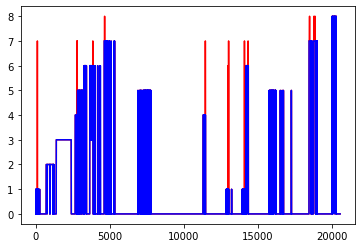

In [ ]:
# demonstrate verify fitting on training
yhat = model.predict(x_train)
yyhat = []
for k in range (0,len(yhat)):
    yh = np.argmax(yhat[k]) # max probability
    yyhat.append(yh)
plt.figure(1)
plt.plot(yyhat,'r', y_train,'b')  


0.9740468945766959


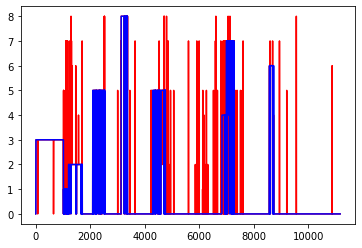

In [ ]:
# test model on testing data 
yhat = model.predict(x_t)
y_pred = []
for k in range (0,len(yhat)):
    yh = np.argmax(yhat[k])
    y_pred.append(yh)
plt.figure(0)
plt.plot(y_pred,'r', y_t,'b')  

accuracy_tb = metrics.accuracy_score(y_t, y_pred)
print(accuracy_tb)

In [ ]:
accuracy_tb = metrics.accuracy_score(y_t, y_pred)

print(accuracy_tb)


TP=TN=FP=FN=0
for k in range (0,len(yhat)):
    ylabel     = y_t[k];
    ypredicted = y_pred[k];
    if ypredicted == 0 and ylabel == 0:
        TN = TN + 1
    elif ypredicted > 0 and ylabel > 0:
        TP = TP + 1
    elif ypredicted > 0 and ylabel == 0:
        FP = FP + 1
    elif ypredicted == 0 and ylabel > 0:
        FN = FN + 1
    else:
        print('any')
print("ACCURACY", (TP+TN)/(TP+TN+FP+FN))
print("F1-SCORE", (2*TP)/(2*TP+FP+FN))
print("FALSE POS. RATE (FPR)", (FP)/(FP+TN))
print("RECALL (TPR)", (TP)/(TP+FN))

metrics.precision_recall_fscore_support(y_t, y_pred, average='micro')

0.9740468945766959
ACCURACY 0.9888133166278862
F1-SCORE 0.9787161586923208
FALSE POS. RATE (FPR) 0.00909090909090909
RECALL (TPR) 0.9829001367989056


(0.9740468945766959, 0.9740468945766959, 0.9740468945766959, None)

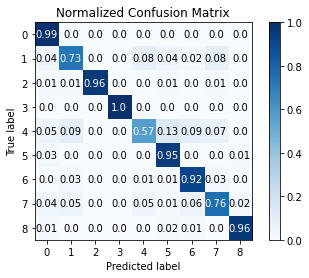

In [ ]:
skplt.metrics.plot_confusion_matrix(y_t,y_pred,normalize="True")

In [ ]:
dump(sc, 'scaler2017.joblib')

['scaler2017.joblib']

In [ ]:
model.save('/content/drive/My Drive/TecM/Noveno Semestre/Tesina/Models/CNN_CICIDS2017_model')   

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/TecM/Noveno Semestre/Tesina/Models/CNN_CICIDS2017_model/assets


***************************************************************
EVALUATE MODEL ON TESTING DATA
350/350 [==============================] - 1s 2ms/step - loss: 0.4907 - sparse_categorical_accuracy: 0.9740
***************************************************************
Assessment: 2 classes
Accuracy 0.9888133166278862
Precision 0.9888566165262966
F1-SCORE 0.9888286385670905
RECALL (TPR) 0.9888133166278862
FALSE POS. RATE (FPR) 0.00909090909090909
***************************************************************
Assessment: n classes
Accuracy 0.9740468945766959
Precision 0.9744218992026482
F1-SCORE 0.9739456094450825
RECALL (TPR) 0.9740468945766959


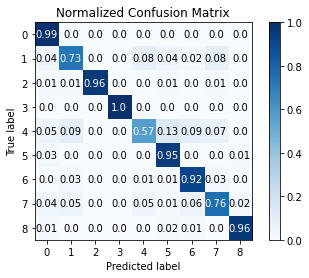

In [ ]:
from sklearn.metrics import accuracy_score, recall_score,f1_score,precision_score,roc_auc_score
print("***************************************************************")
print("EVALUATE MODEL ON TESTING DATA")
results = model.evaluate(x_t, y_t)
yhat = model.predict(x_t)
yyhat = []
for k in range (0,len(yhat)):
    yh = np.argmax(yhat[k])
    yyhat.append(yh)
print("***************************************************************")    
print("Assessment: 2 classes") 
TP=TN=FP=FN=0
y_test2c = np.array(y_t)
y_test2c [y_test2c>=1] = 1;
y_hat2c = np.array(yyhat)
y_hat2c [y_hat2c>=1] = 1;
print("Accuracy", accuracy_score(y_test2c, y_hat2c))
print("Precision", precision_score(y_test2c, y_hat2c, average='weighted'))
print("F1-SCORE", f1_score(y_test2c, y_hat2c, average='weighted'))
print("RECALL (TPR)", recall_score(y_test2c, y_hat2c, average='weighted'))
 
for k in range (0,len(yhat)):
    ylabel     = y_t[k];
    ypredicted = yyhat[k];
    if ypredicted == 0 and ylabel == 0:
        TN = TN + 1
    elif ypredicted > 0 and ylabel > 0:
        TP = TP + 1
    elif ypredicted > 0 and ylabel == 0:
        FP = FP + 1
    elif ypredicted == 0 and ylabel > 0:
        FN = FN + 1
    else:
        print('any')
# print("ACCURACY", (TP+TN)/(TP+TN+FP+FN))
# print("Precision ", (TP)/(TP+FP))
# print("F1-SCORE", (2*TP)/(2*TP+FP+FN))
# print("RECALL (TPR)", (TP)/(TP+FN))
print("FALSE POS. RATE (FPR)", (FP)/(FP+TN))


print("***************************************************************") 
print("Assessment: n classes") 
print("Accuracy", accuracy_score(y_t, yyhat))
print("Precision", precision_score(y_t, yyhat, average='weighted'))
print("F1-SCORE", f1_score(y_t, yyhat, average='weighted'))
print("RECALL (TPR)", recall_score(y_t, yyhat, average='weighted'))

skplt.metrics.plot_confusion_matrix(y_t,yyhat,normalize="True")


# Time complexity Analysis



In [36]:
import timeit

def prediction():
  yhat = model.predict(x_t[0:10000]);

# load model and testing data

execution_time = timeit.repeat(prediction, number=1, repeat=100)
print('Average Flow/s: ', 1/((min(execution_time))/10000))



Average Flow/s:  32797.517125628285
